In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

- Export the weights along the trajectory for both models
- combine
- PCA
- interpolate (+- 10%)
- create set of weights
- probe loss of both networks
    - convert BP net to ReLU before computing loss
- plot 2D loss landscape as 3D heatmap (including 2 actual trajectories, plot separately)

In [2]:
input_size = 21
dataset = torch.eye(input_size) #each row is a different pattern
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                        shuffle=True, 
                        generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21)
epochs=30
seed=42

### Gjorgjieva learning rule

In [3]:
network_config = ut.read_from_yaml('../optimize/data/20220902_EIANN_1_hidden_Gjorgieva_Hebb_config_A.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

gj_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

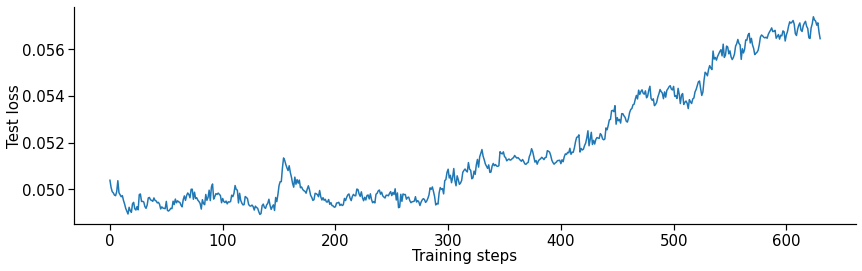

In [4]:
data_generator.manual_seed(data_seed)
gj_network.train(dataloader, epochs, store_history=True, status_bar=True)

pt.plot_test_loss_history(gj_network, test_dataloader)

  0%|          | 0/630 [00:00<?, ?it/s]

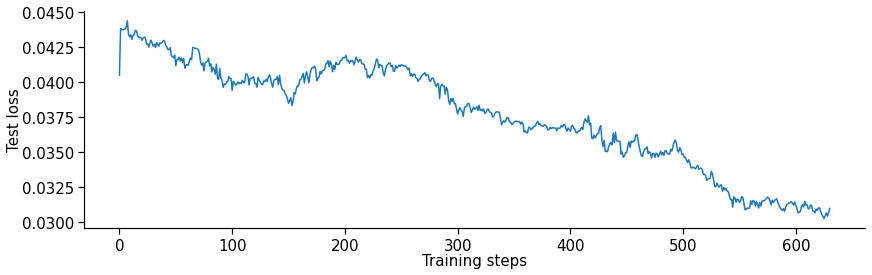

In [5]:
min_loss_sorting = ut.get_optimal_sorting(gj_network, test_dataloader)
ut.recompute_history(gj_network, min_loss_sorting)

pt.plot_test_loss_history(gj_network, test_dataloader)

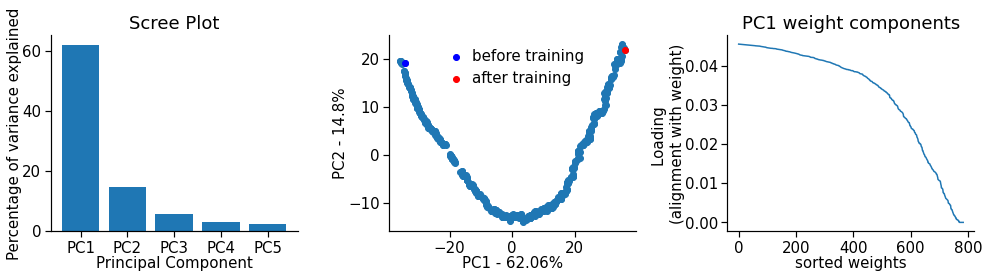

In [6]:
pt.plot_weight_history_PCs(gj_network)

  0%|          | 0/400 [00:00<?, ?it/s]

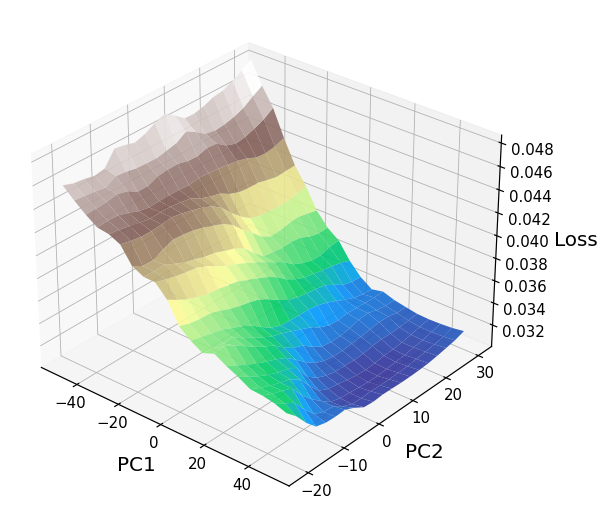

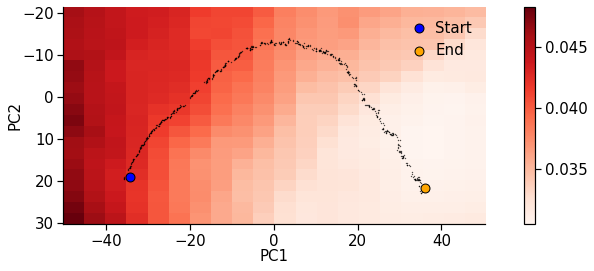

In [7]:
pt.plot_loss_landscape(gj_network, test_dataloader, num_points=20)

### Backprop (softplus; SGD)

In [8]:
network_config = ut.read_from_yaml('../config/EIANN_1_hidden_backprop_softplus_SGD_matched_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

In [9]:
# Initialize backprop net with same weights as Gjorg. init
gj_initial_state = gj_network.param_history[0]
bp_network.load_state_dict(gj_initial_state)

<All keys matched successfully>

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

Samples:   0%|          | 0/21 [00:00<?, ?it/s]

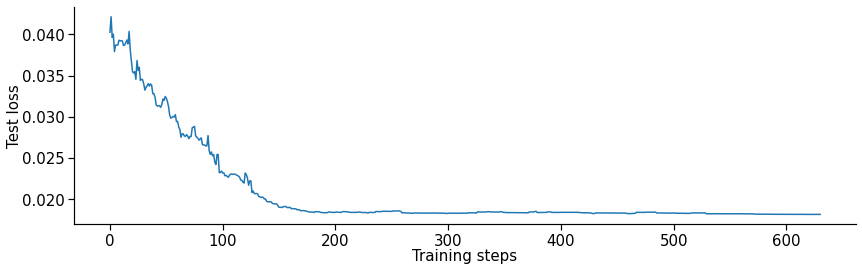

In [10]:
data_generator.manual_seed(data_seed)
bp_network.train(dataloader, epochs, store_history=True, status_bar=True)

pt.plot_test_loss_history(bp_network, test_dataloader)

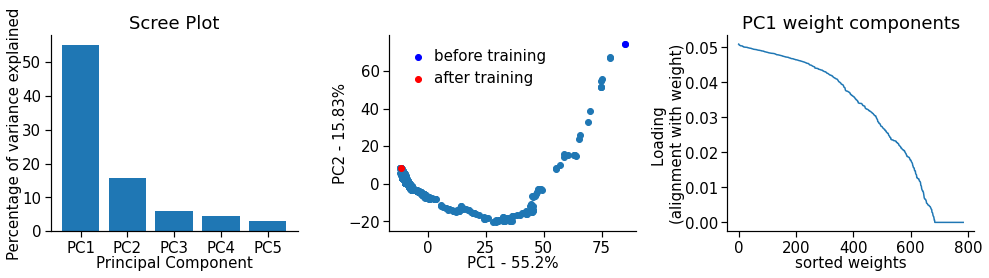

In [11]:
pt.plot_weight_history_PCs(bp_network)

  0%|          | 0/400 [00:00<?, ?it/s]

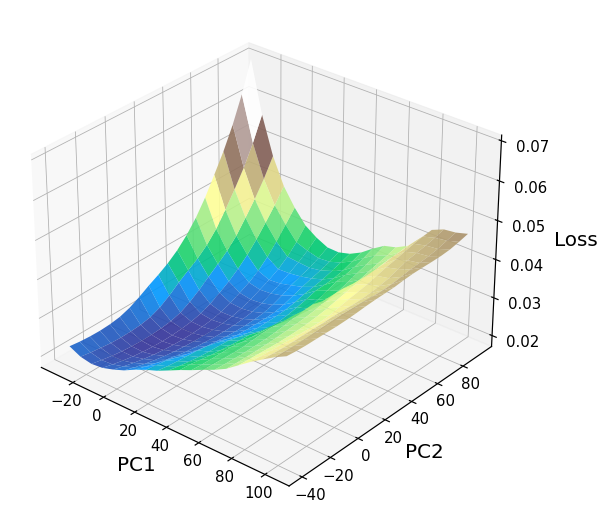

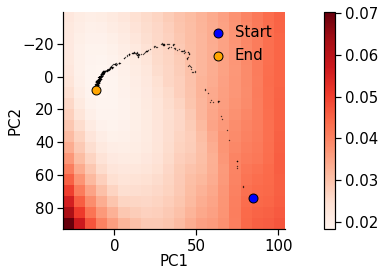

In [12]:
pt.plot_loss_landscape(bp_network, test_dataloader, num_points=20)

## Combined loss landscape

  0%|          | 0/400 [00:00<?, ?it/s]

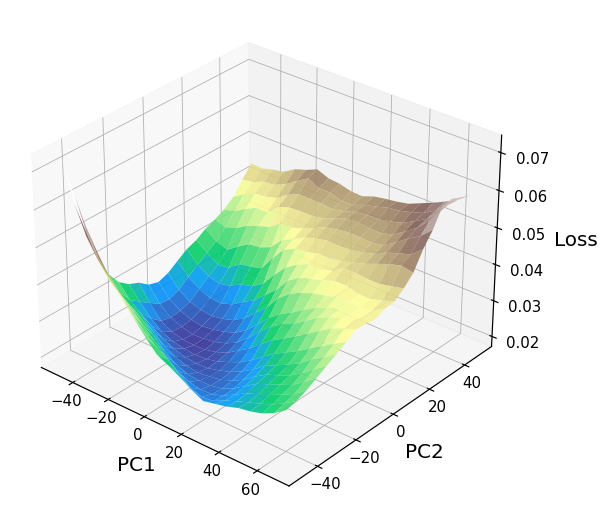

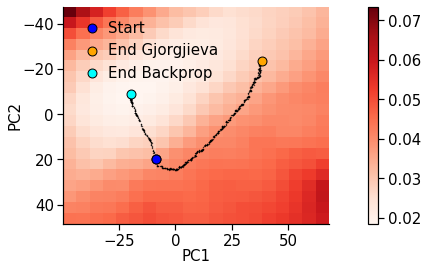

In [13]:
gj_network.name = 'Gjorgjieva'
bp_network.name = 'Backprop'
pt.plot_combined_loss_landscape(gj_network, bp_network, test_dataloader, num_points=20, extension=0.5)

In [14]:
# check that forward through re-sorted weights is same as output history

# check that loss landscape grid is same for both networks

# add biases to PCA

# PCA plot for combined weights